In [1]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_seaborn
%run -m ipy_plotly
%matplotlib inline
from mgds.data_aggregation import api
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import data_type as dtyp
from mgds.data_aggregation import entity
from mgds.data_modeling import data_broker as dbm
from mgds.data_modeling import training01 as rx_train
from py_utils import collection_utils

2017-02-18 10:49:33,132:DEBUG:requests.packages.urllib3.connectionpool: Starting new HTTPS connection (1): api.plot.ly


In [2]:
import imp
imp.reload(rx_train)

<module 'mgds.data_modeling.training01' from '/Users/eczech/repos/mgds/python/src/mgds/data_modeling/training01.py'>

In [2]:
training_type = 'multi_source'
versions = rx_train.get_training_result_versions(training_type)
d = {v:rx_train.get_training_results(training_type, v) for v in versions}

2017-02-18 10:49:36,151:DEBUG:py_utils.io_utils: Restoring serialized object "Training Results" from location "/Users/eczech/data/research/mgds/modeling/rx/results/multi_source/v1/results.pkl"
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/base.py:315: UserWarning:

Trying to unpickle estimator SelectKBest from version pre-0.18 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.

2017-02-18 10:49:38,416:DEBUG:py_utils.io_utils: Restoring serialized object "Training Results" from location "/Users/eczech/data/research/mgds/modeling/rx/results/multi_source/v2/results.pkl"
2017-02-18 10:49:40,495:DEBUG:py_utils.io_utils: Restoring serialized object "Training Results" from location "/Users/eczech/data/research/mgds/modeling/rx/results/multi_source/v3/results.pkl"
2017-02-18 10:49:42,499:DEBUG:py_utils.io_utils: Restoring serialized object "Training Results" from location "/Users/eczech/data/research/mgds/modeling/rx/res

In [57]:
import imp
imp.reload(rx_train)

<module 'mgds.data_modeling.training01' from '/Users/eczech/repos/mgds/python/src/mgds/data_modeling/training01.py'>

In [6]:
import pdb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def _get_scores(d_pred):
    # Greater should always be better
    score_functions = {
        'r2': lambda y_true, y_pred: r2_score(y_true, y_pred) if len(y_true) > 0 else np.nan,
        'corr': lambda y_true, y_pred: y_pred.corr(y_true) if len(y_true) > 0 else np.nan,
        'mse': lambda y_true, y_pred: -mean_squared_error(y_true, y_pred) if len(y_true) > 0 else np.nan,
        'mae': lambda y_true, y_pred: -mean_absolute_error(y_true, y_pred) if len(y_true) > 0 else np.nan
    }
    return rx_train.get_scores(d_pred, score_functions)
    
def get_scores():
    d_score = []
    site = 'BREAST'
    for v in d:
        d_pred = d[v]['res'][site]['prediction_data']
        d_score.append(_get_scores(d_pred).assign(VERSION=v))
    return pd.concat(d_score)

d_score = get_scores()

/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/numpy/lib/function_base.py:2496: RuntimeWarning:

divide by zero encountered in double_scalars



In [7]:
d_score.head()

SOURCE              DRUG  MODEL_NAME  FOLD_ID METRIC         VALUE VERSION
0  gdsc_v2  gdsc_v2:AG014699  meta_lasso        1   corr  6.444394e-01      v1
1  gdsc_v2  gdsc_v2:AG014699  meta_lasso        2   corr -1.269186e-15      v1
2  gdsc_v2  gdsc_v2:AG014699  meta_lasso        3   corr  1.748781e-01      v1
3  gdsc_v2  gdsc_v2:AG014699  meta_lasso        4   corr  9.992845e-02      v1
4  gdsc_v2  gdsc_v2:AG014699  meta_lasso        5   corr -2.732357e-01      v1

In [9]:
d_score_mean = d_score.groupby(['DRUG', 'VERSION', 'MODEL_NAME', 'METRIC'])['VALUE'].mean().reset_index()
d_score_mean['VERSION'] = d_score_mean['VERSION'].str.replace('v', '').astype(np.int64)
#d_score.groupby(['DRUG_NAME', 'VERSION']).apply(lambda g: g.sort_values('VALUE', ascending=False).head(1))

In [10]:
d_score_mean.head()

DRUG  VERSION      MODEL_NAME METRIC      VALUE
0  ctd_v2:NAVITOCLAX        6    meta_std_avg   corr   0.036960
1  ctd_v2:NAVITOCLAX        6    meta_std_avg    mae  -8.516739
2  ctd_v2:NAVITOCLAX        6    meta_std_avg    mse -76.813808
3  ctd_v2:NAVITOCLAX        6    meta_std_avg     r2 -50.358158
4  ctd_v2:NAVITOCLAX        6  meta_std_lasso   corr  -0.047258

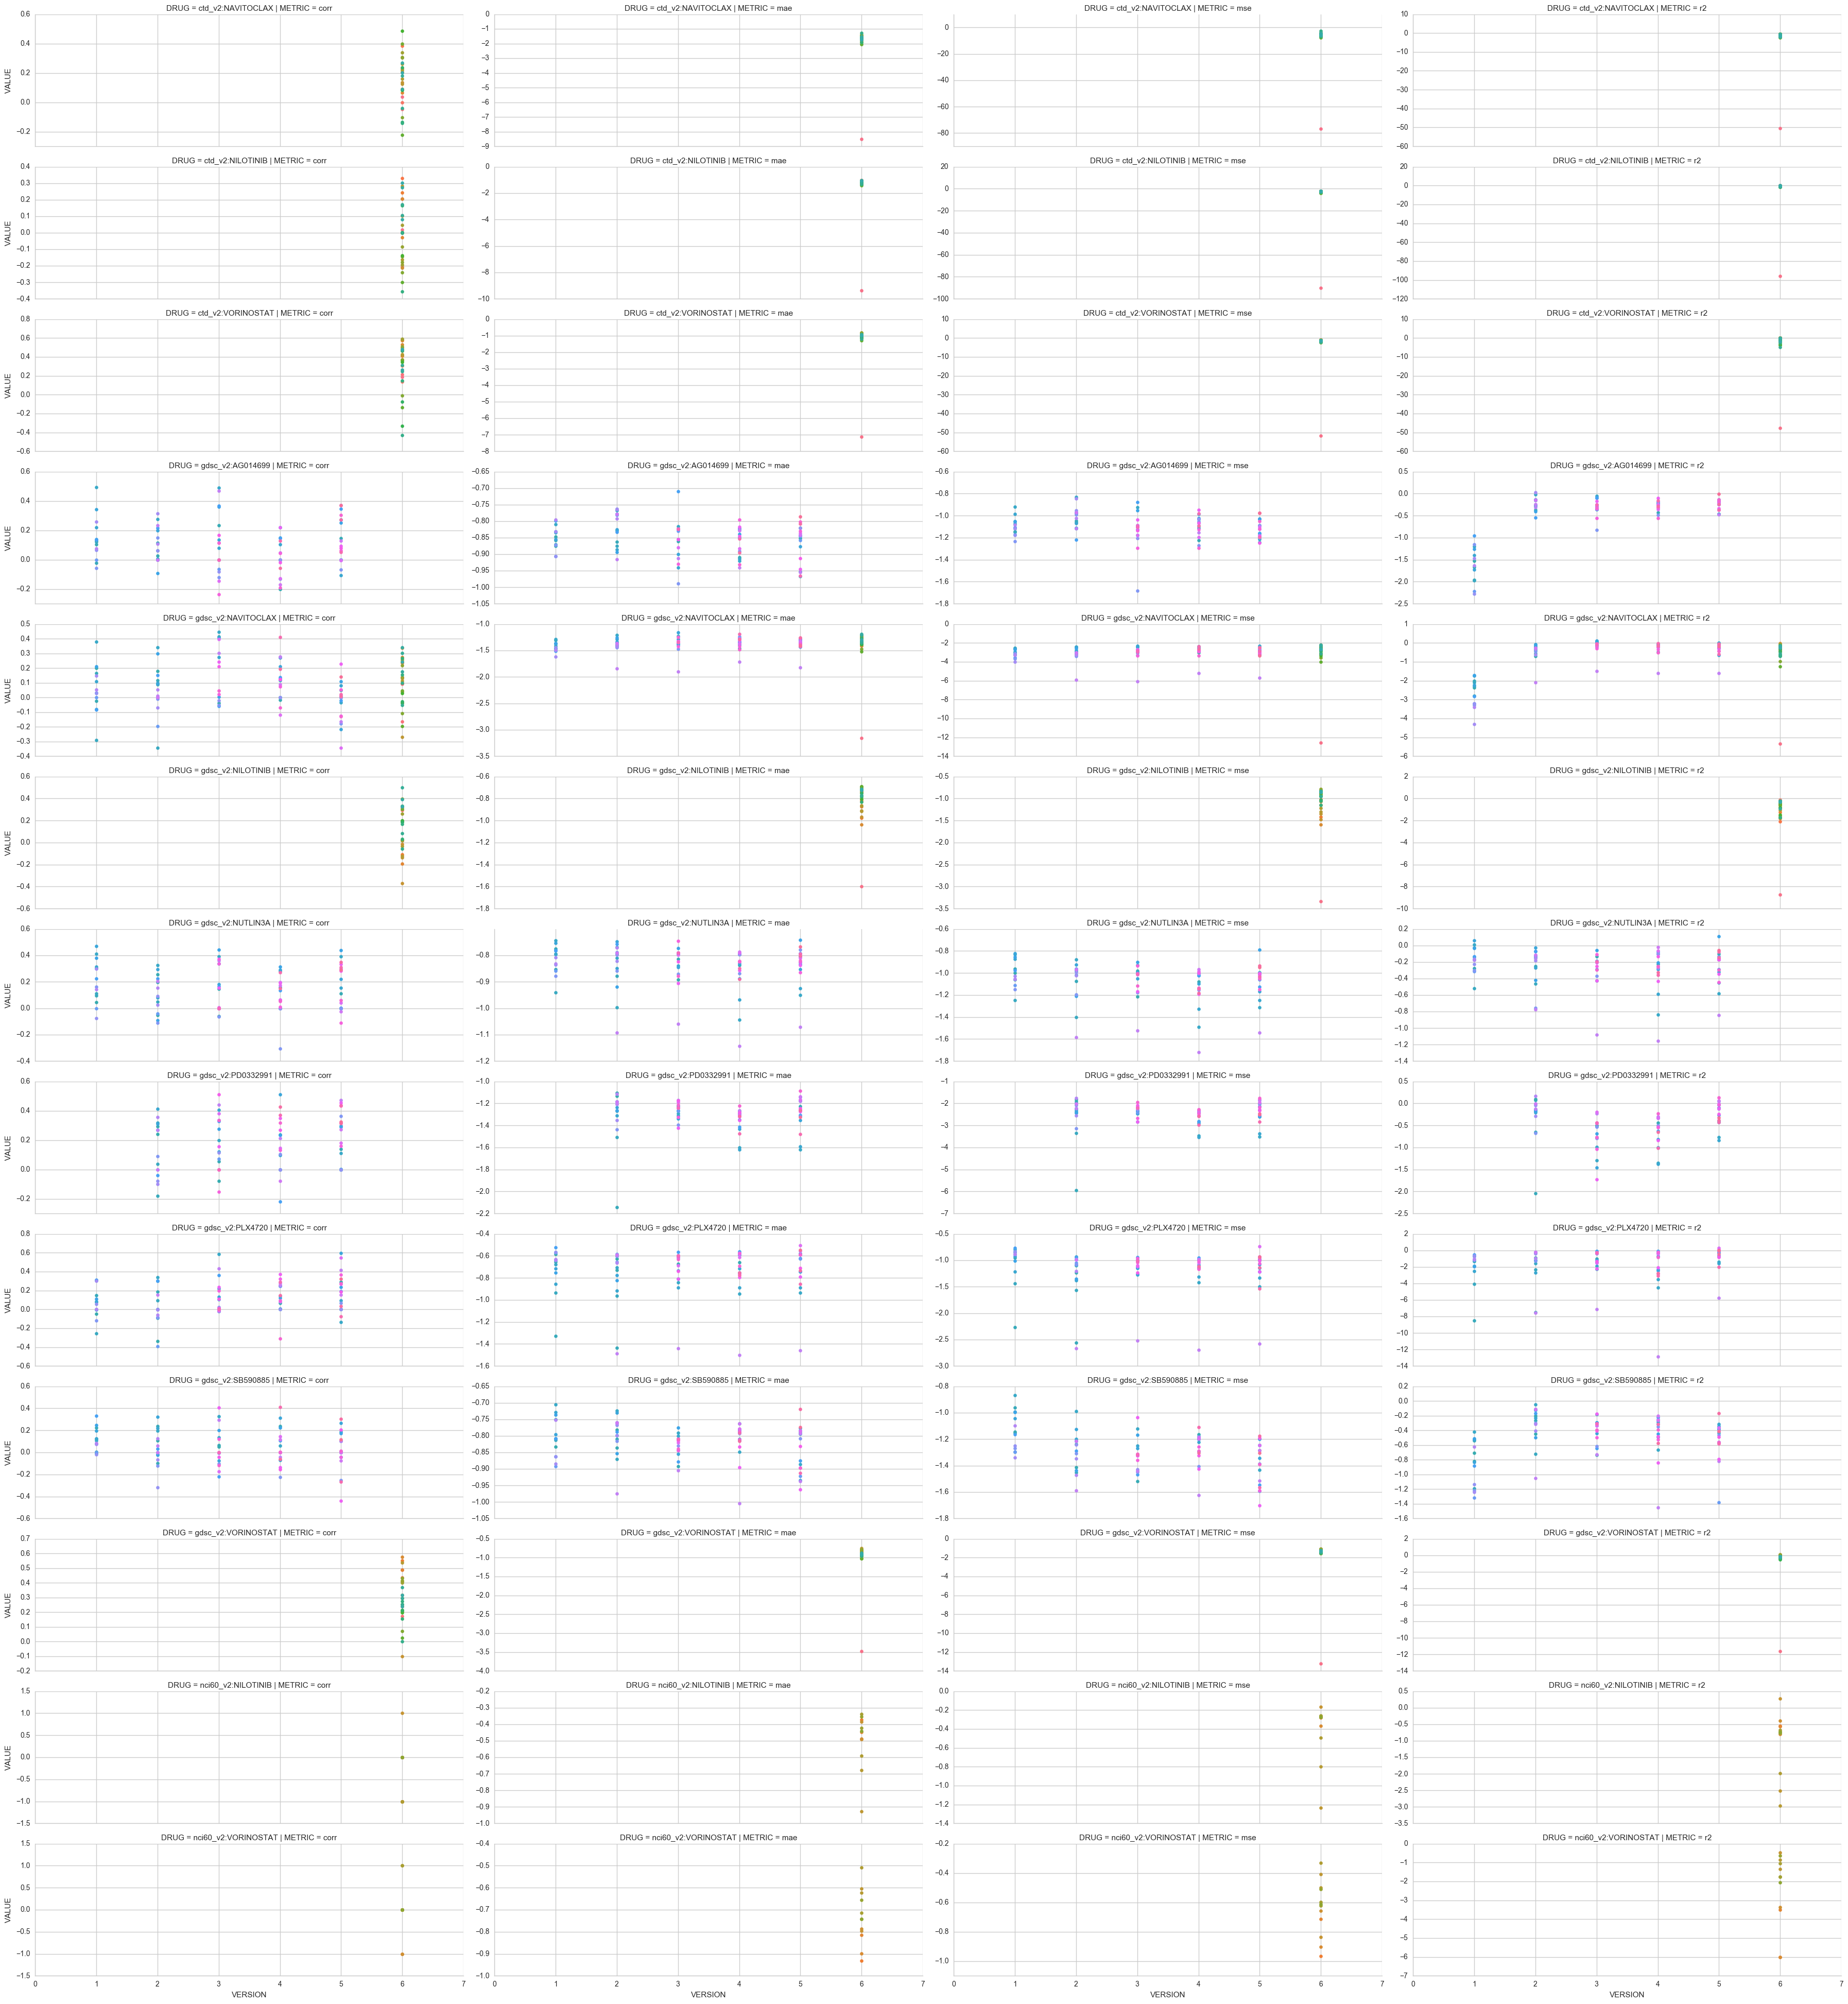

In [12]:
g = sns.FacetGrid(d_score_mean, row='DRUG', col='METRIC', hue='MODEL_NAME', sharey=False, aspect=3)
g.map(plt.scatter, 'VERSION', 'VALUE')

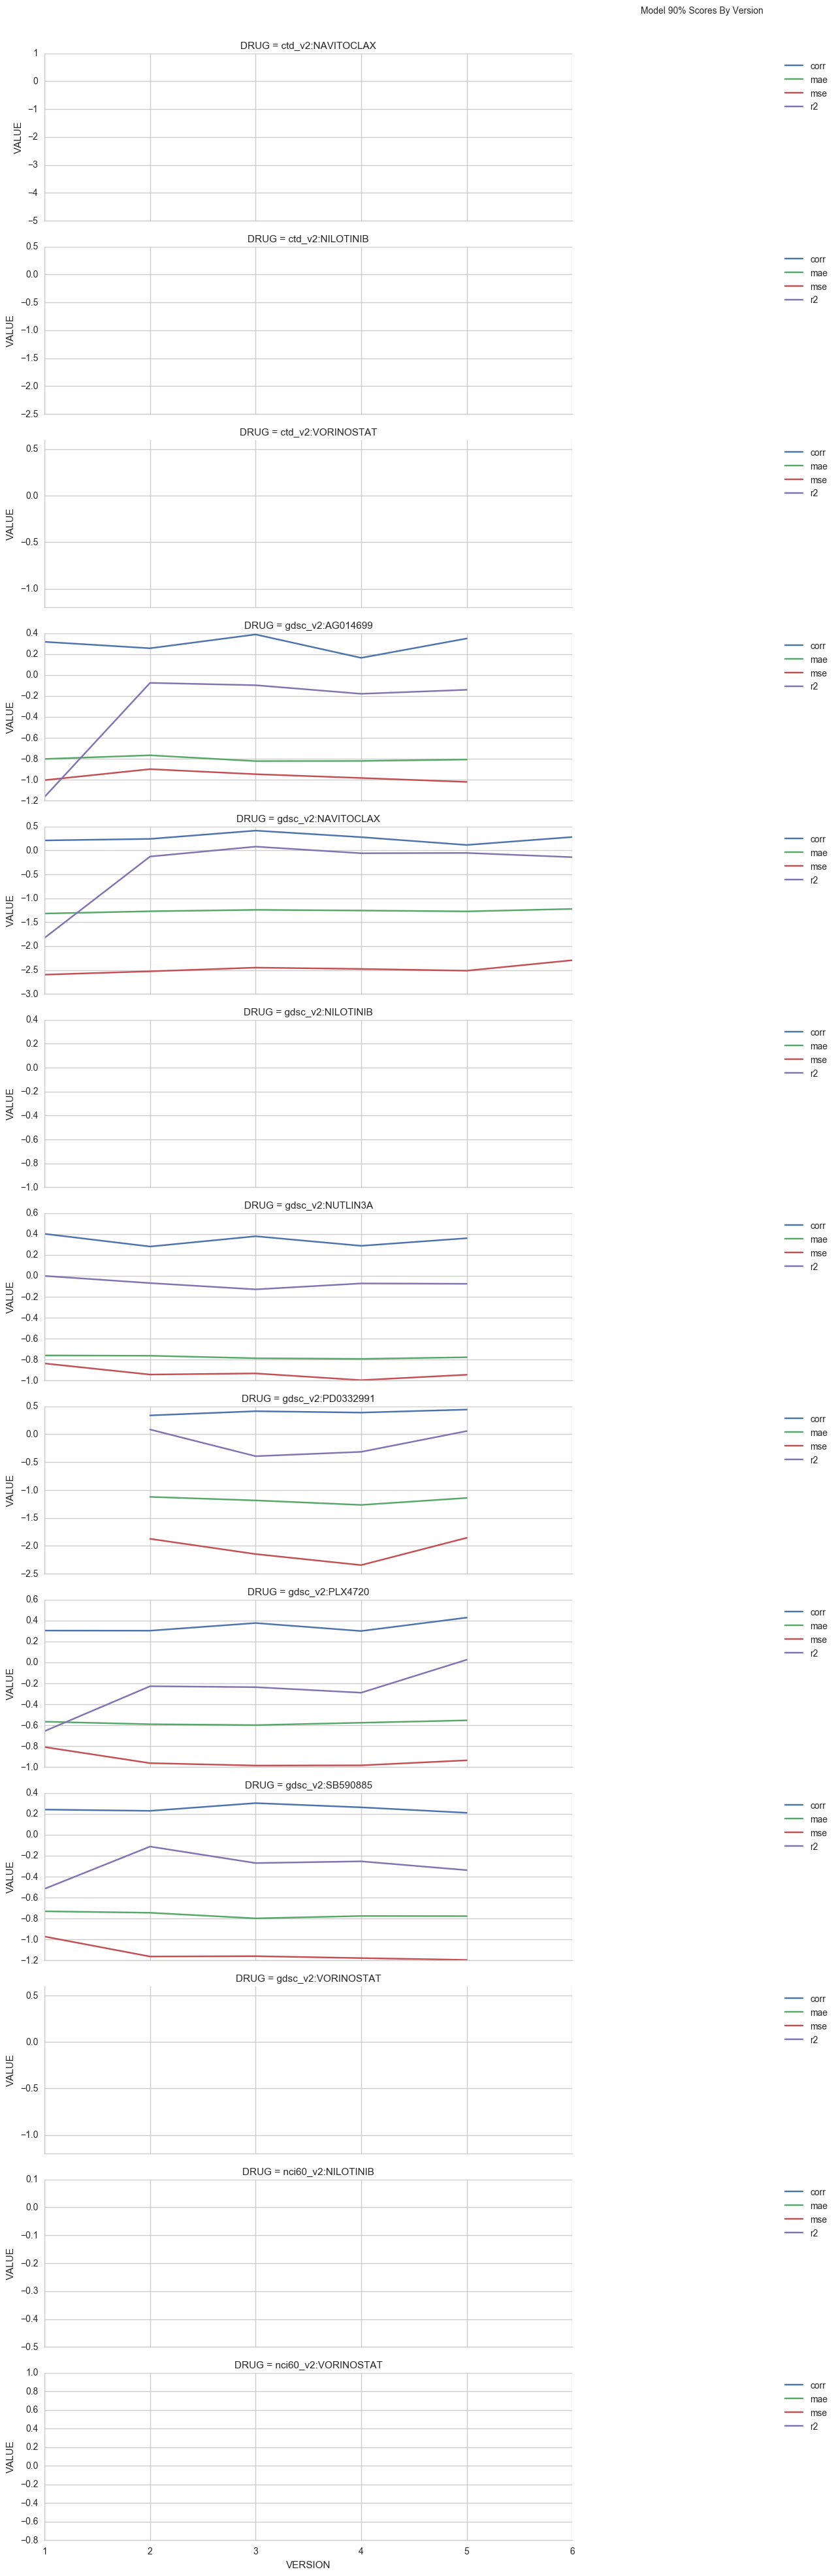

In [11]:
g = sns.FacetGrid(
    d_score_mean.groupby(['DRUG', 'VERSION', 'METRIC'])['VALUE'].quantile(.9).reset_index(),
    row='DRUG', hue='METRIC', sharey=False, size=3, aspect=3
)
g.map(plt.plot, 'VERSION', 'VALUE')
[ax.legend(bbox_to_anchor=(1.5, 1)) for ax in g.axes.ravel()]
g.fig.suptitle('Model 90% Scores By Version', x=1.2, y=1.01)
print()

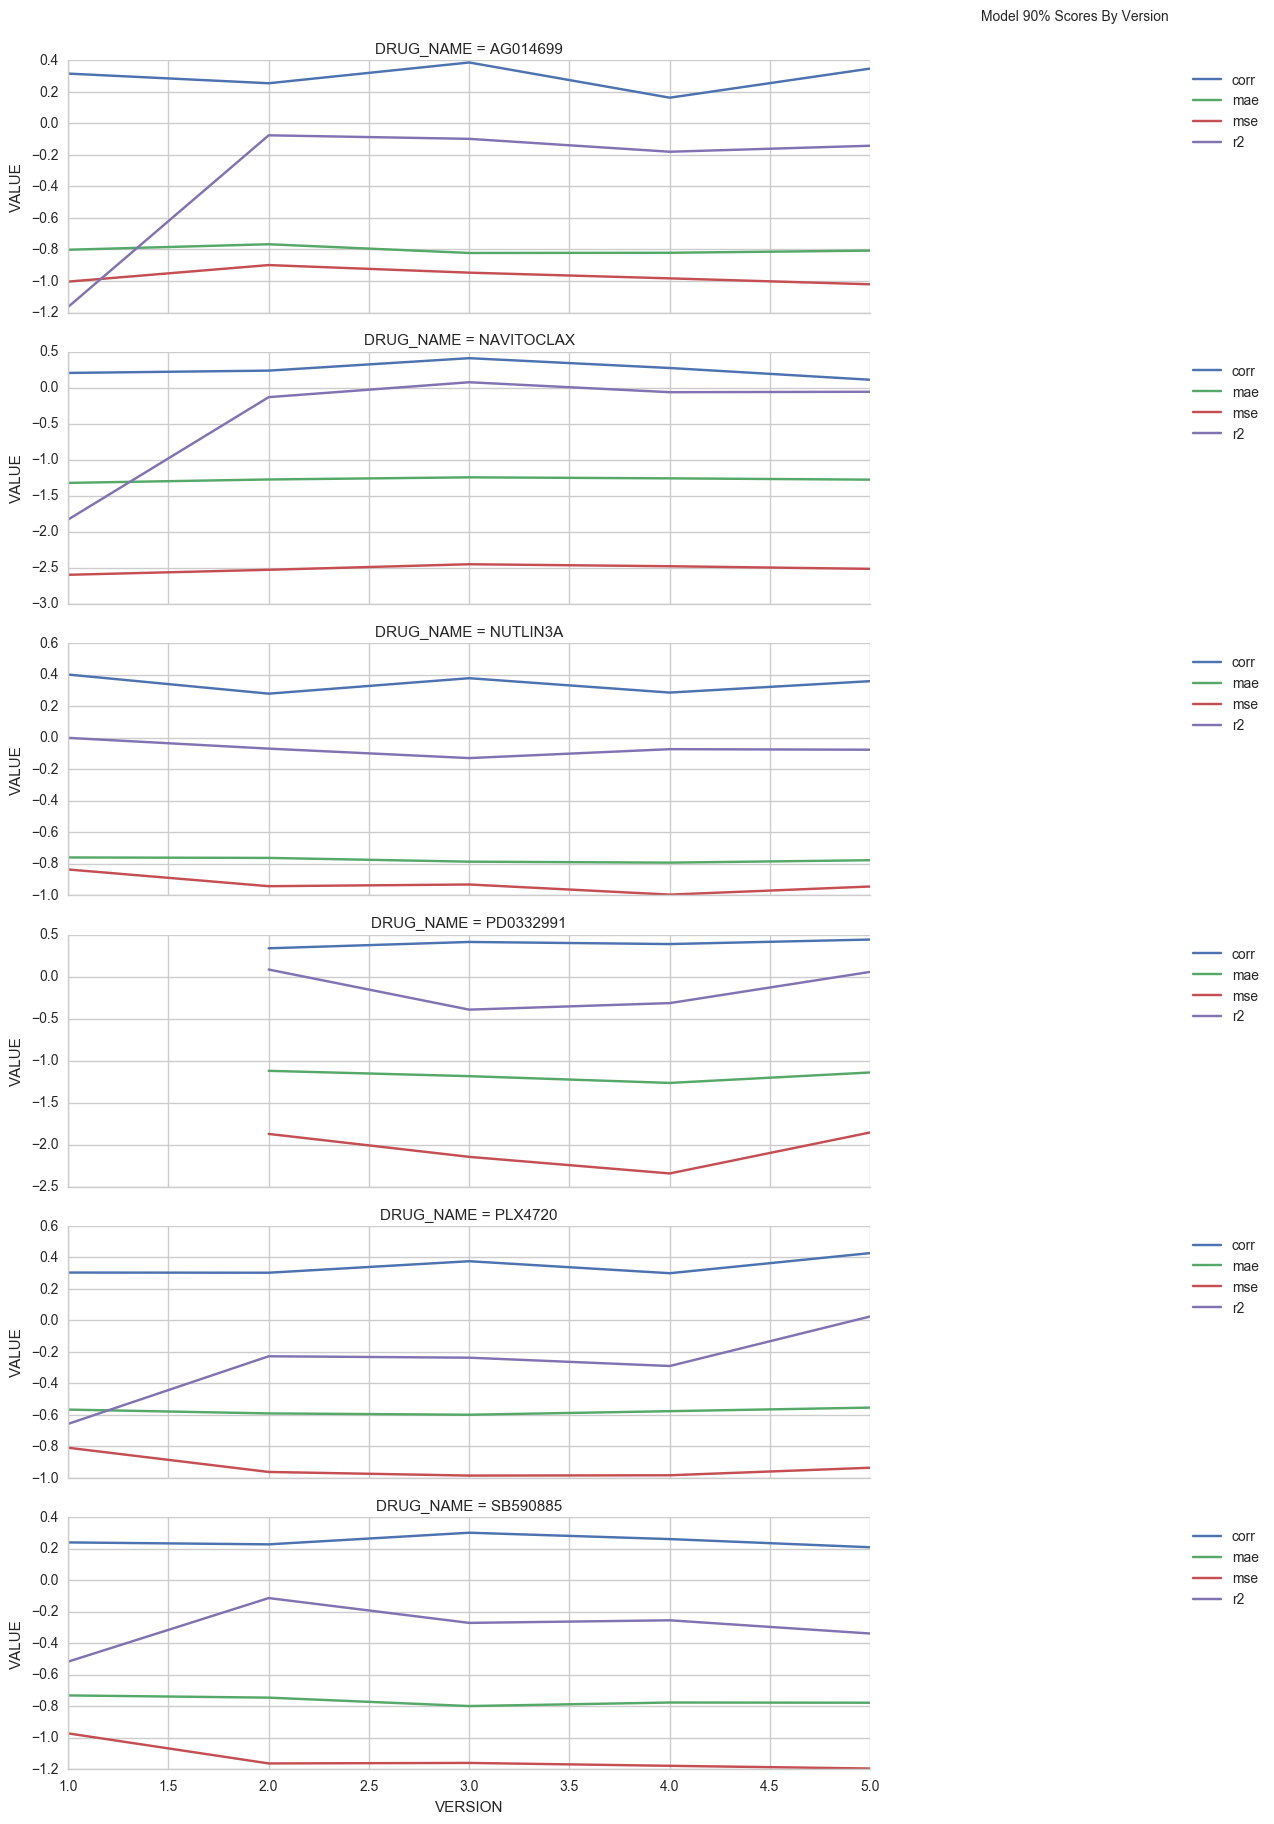

In [66]:
g = sns.FacetGrid(
    d_score_mean.groupby(['DRUG_NAME', 'VERSION', 'METRIC'])['VALUE'].quantile(.9).reset_index(),
    row='DRUG_NAME', hue='METRIC', sharey=False, size=3, aspect=3
)
g.map(plt.plot, 'VERSION', 'VALUE')
[ax.legend(bbox_to_anchor=(1.5, 1)) for ax in g.axes.ravel()]
g.fig.suptitle('Model 90% Scores By Version', x=1.2, y=1.01)
print()